<a href="https://colab.research.google.com/github/WaleAdelanwa/Data-Science-Projects/blob/main/03_transformer_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transformer-Based Classification with BERT

### Notebook 3
Having built a classical baseline with TF-IDF + Logistic Regression, I proceed to **deep learning** using transformer models. This approach allows me to go beyond surface-level keyword frequency and tap into the **contextual meaning of sentences**.

My plan is to train a BERT-based model to classify articles into the manually labeled **subcategories** using the `master_bbc_labeled.csv` dataset.

### Why Transformers?
- Understand **semantics**, not just words
- Handle ambiguous or rare categories better
- Capture long-range dependencies in text

In this notebook, I will:
1. **Load and inspect the labeled master dataset**
2. **Preprocess**: Encode labels, tokenize text
3. **Fine-tune BERT** with HuggingFace Transformers
4. **Evaluate**: Metrics + Confusion Matrix
5. **Save** the model and sample predictions

I will use **Google Colab** for this section due to the GPU requirements of fine-tuning transformer models efficiently.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
import torch

# Load labeled data
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/MyDrive/bbc_nlp_challenge/master_bbc_labeled.csv")
df['text'] = df['text'].astype(str)
df = df[df['sub_category'].notnull()].reset_index(drop=True)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,filename,category,text,topic,sub_category
0,289.txt,sport,Fuming Robinson blasts officials\n\nEngland co...,1,rugby
1,504.txt,sport,Veteran Martinez wins Thai title\n\nConchita M...,2,tennis
2,262.txt,sport,Spurs to sign Iceland U21 star\n\nTottenham ar...,0,football
3,276.txt,sport,Mexicans tracking unhappy Juninho\n\nMexican o...,0,football
4,510.txt,sport,Mirza makes Indian tennis history\n\nTeenager ...,2,tennis


## Step 2: Encode Labels and Prepare Dataset

To train a transformer model, subcategory labels needs to be converted into numerical form. This is done using **label encoding**. Next, I will split the data into training and testing sets, and then wrap it using HuggingFace’s `Dataset` format for compatibility with the Trainer API.


In [3]:
# Encode labels
le = LabelEncoder()
df["label"] = le.fit_transform(df["sub_category"])

# Save for later decoding
label_names = le.classes_
num_labels = len(label_names)

# Split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"], df["label"], test_size=0.2, stratify=df["label"], random_state=42
)

# Load tokenizer
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Tokenize
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

# Format for HuggingFace
train_dataset = Dataset.from_dict({
    "text": train_texts,
    "labels": train_labels,
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
})

test_dataset = Dataset.from_dict({
    "text": test_texts,
    "labels": test_labels,
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
})

train_dataset, test_dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

(Dataset({
     features: ['text', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 1780
 }),
 Dataset({
     features: ['text', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 445
 }))

## Step 3: Load Model and Configure Training

I will fine-tune a pre-trained `distilbert-base-uncased` model for **multi-class classification** across news subcategories.

Key things to do:
- Load the model with the correct number of output labels
- Set up training hyperparameters (batch size, learning rate, number of epochs)
- Define a metric function to evaluate performance

In [5]:
# Load pre-trained transformer model for classification
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=num_labels
)

# Set training arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs"
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = (preds == labels).mean()
    return {"accuracy": acc}

Having configured the model and training arguments, the next step was to prepare the data for training.

Since transformer models require tokenized input, I used the `AutoTokenizer` associated with the `distilbert-base-uncased` checkpoint. I defined a simple tokenization function that applies truncation to ensure input texts do not exceed the model’s maximum length.

I then applied this tokenization function to both the training and test datasets using the `.map()` method from the Hugging Face `datasets` library. This step ensures that all input text is properly preprocessed before being passed into the model.

In [8]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/1780 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

With the tokenized datasets ready, I proceeded to reload the transformer model—this time specifying the number of output labels. This step is necessary to adapt the pre-trained `distilbert-base-uncased` model for the multi-class classification task.

The number of output labels is determined by the number of unique subcategories identified earlier in the labeled dataset. I retrieved this count from the label encoder used during preprocessing and passed it into the model initialization.

In [9]:
num_labels = len(label_encoder.classes_)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Next, I will define the final runtime configuration for training.

First, I will initialize a `DataCollatorWithPadding` to ensure that within each batch, all sequences are padded to the length of the longest example. This allows the model to handle variable-length inputs efficiently without unnecessary memory overhead.

Then, I will set up the `TrainingArguments`, which control the training loop. These include:
- Training the model for 5 epochs
- Using a learning rate of `2e-5` and weight decay for regularization
- Setting a batch size of 8 for both training and evaluation
- Logging progress and saving checkpoints after every epoch
- Automatically restoring the best model based on validation accuracy at the end of training

These configurations are designed to balance performance and efficiency during fine-tuning.

In [13]:
from transformers import TrainingArguments, DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

Defining how model's performance should be evaluated during training.

To do this, I will use the `evaluate` library from Hugging Face to track classification **accuracy** as the primary metric. I will define a `compute_metrics` function that:
- Takes the raw model outputs (`logits`) and true labels
- Applies `argmax` to convert logits into predicted class indices
- Computes the accuracy score by comparing predictions to actual labels

This metric will be used to assess model performance on the validation set after each epoch, and also determine which model checkpoint performs best.

In [16]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [15]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00


Next I am initializing the Hugging Face `Trainer`.

The `Trainer` simplifies the training process by wrapping the model, data, tokenizer, training arguments, and evaluation function into a single interface. It automatically handles:
- Forward and backward passes
- Evaluation on the validation set after each epoch
- Logging and checkpointing
- Metric computation using the `compute_metrics` function defined earlier

Once the `Trainer` is set up, I will launch the training using `trainer.train()`.

In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/tmp/ipython-input-19-4113992272.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wale-adelanwa22 (wale-adelanwa22-talence) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.162299,0.555056
2,No log,1.602251,0.642697
3,2.365400,1.335552,0.685393
4,2.365400,1.205483,0.728090
5,1.252500,1.164310,0.730337


TrainOutput(global_step=1115, training_loss=1.7309425525066564, metrics={'train_runtime': 667.4021, 'train_samples_per_second': 13.335, 'train_steps_per_second': 1.671, 'total_flos': 1177396681133952.0, 'train_loss': 1.7309425525066564, 'epoch': 5.0})

After training the model for 5 epochs, I will now evaluate its performance on the test dataset.

To do this, I will:
- Use the trained `Trainer` object to generate predictions on the test set
- Extract the true labels and predicted class indices
- Use `classification_report` from `scikit-learn` to compute precision, recall, and F1-score for each class

This will give a detailed breakdown of how well the model performed across all subcategories, and highlight any classes that may have been harder to classify correctly.

In [20]:
preds = trainer.predict(test_dataset)
y_true = test_dataset["label"]
y_pred = np.argmax(preds.predictions, axis=-1)

print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


                                     precision    recall  f1-score   support

                   airline_industry       0.00      0.00      0.00         2
              asian_market_recovery       1.00      0.25      0.40         4
                automotive_industry       0.86      1.00      0.92         6
                  aviation_industry       0.67      0.67      0.67         3
     broadband_and_digital_services       0.75      0.75      0.75        12
chipsets_and_computing_architecture       0.00      0.00      0.00         2
                  cinema_and_awards       0.94      1.00      0.97        34
           civil_rights_and_justice       0.88      0.78      0.82         9
              constitutional_reform       0.00      0.00      0.00         3
              consumer_digital_tech       0.00      0.00      0.00         3
                    corporate_fraud       1.00      0.60      0.75        10
                    currency_market       0.00      0.00      0.00         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


To complement the classification report, I will also visualize the **confusion matrix**.

This matrix provides a clear picture of how often each subcategory is correctly predicted versus misclassified. It helps identify:
- Which subcategories are most frequently confused with others
- Patterns of misclassification that may suggest overlapping label semantics
- Strongly performing categories vs. weak ones

The heatmap will plot the actual labels on the y-axis and predicted labels on the x-axis, giving an intuitive view of where the model excels or struggles.

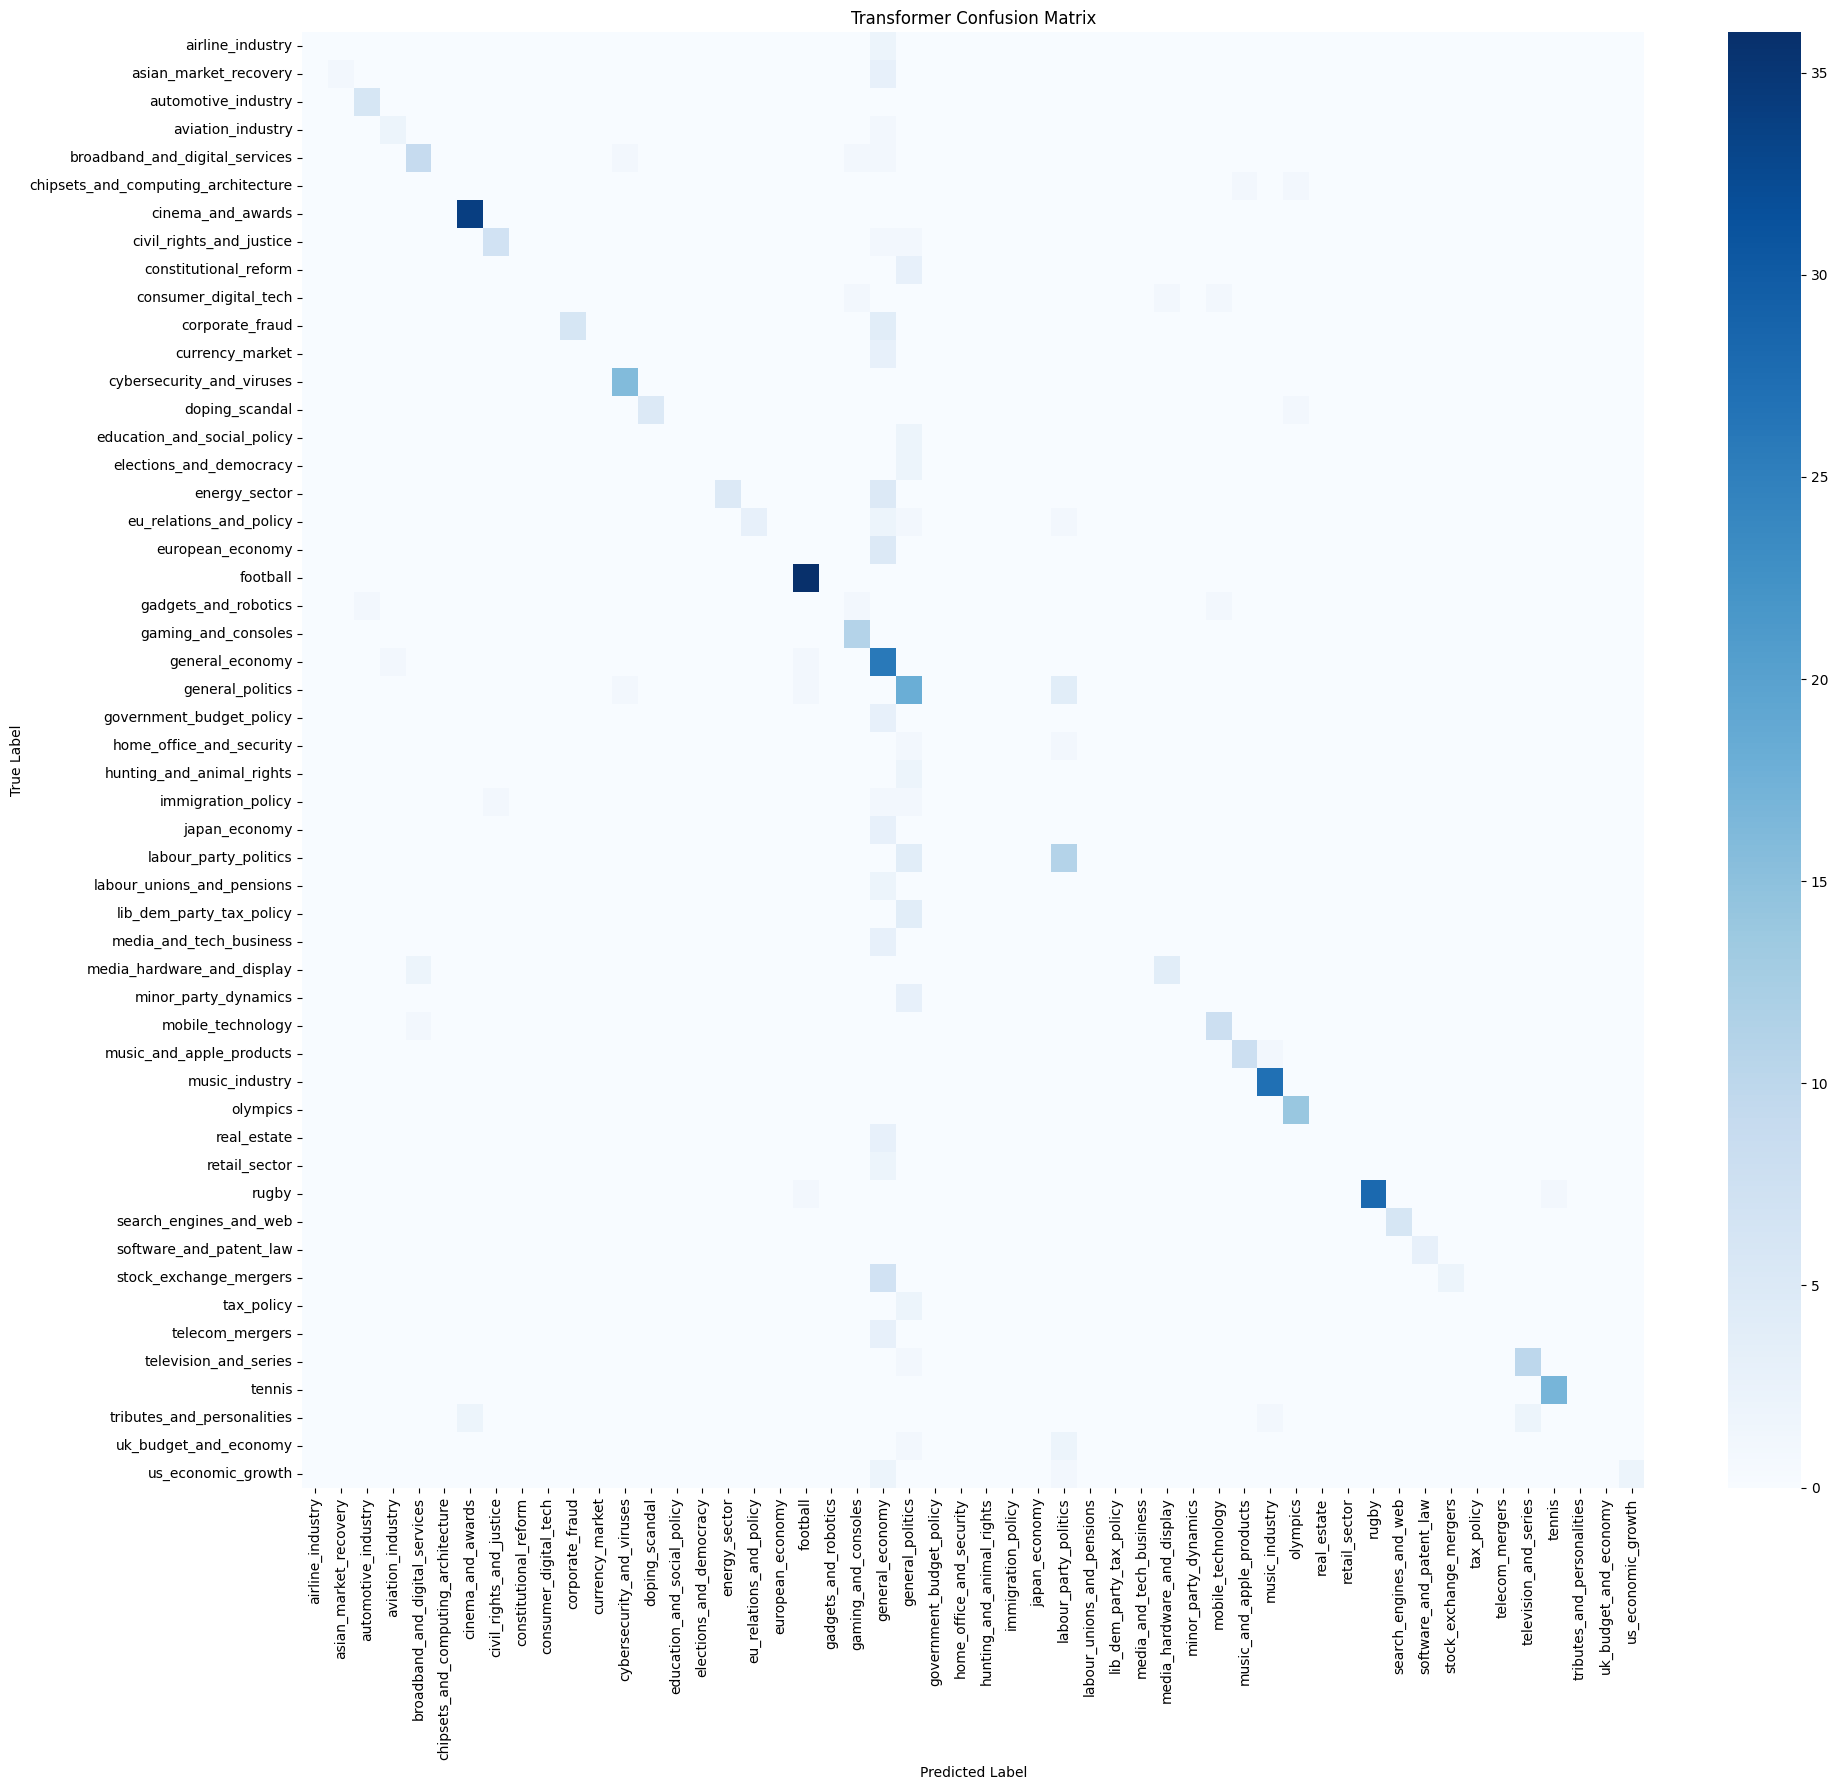

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict with model
preds_output = trainer.predict(test_dataset)
y_true = test_dataset['label']
y_pred = np.argmax(preds_output.predictions, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = label_encoder.classes_

# Plot
plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Transformer Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Saving the fine-tuned transformer model and tokenizer.

It ensures that I don’t have to retrain from scratch in the future. It also allows the model to be reused or deployed in downstream applications like inference pipelines, dashboards, or APIs.

Both the model and tokenizer will be saved to my Google Drive under the specified folder for easy access.

In [22]:
model_save_path = "/content/drive/MyDrive/bbc_nlp_challenge/transformer_model"
tokenizer_save_path = model_save_path

model.save_pretrained(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

('/content/drive/MyDrive/bbc_nlp_challenge/transformer_model/tokenizer_config.json',
 '/content/drive/MyDrive/bbc_nlp_challenge/transformer_model/special_tokens_map.json',
 '/content/drive/MyDrive/bbc_nlp_challenge/transformer_model/vocab.txt',
 '/content/drive/MyDrive/bbc_nlp_challenge/transformer_model/added_tokens.json',
 '/content/drive/MyDrive/bbc_nlp_challenge/transformer_model/tokenizer.json')

To make the model predictions more interpretable, I will decode the numeric label predictions back into their original subcategory names using the label encoder.

I will then compile a DataFrame containing:
- The true label
- The predicted label
- The original article text

This will allow for easy inspection of prediction quality, spot-checking misclassifications, and deeper error analysis if needed. The resulting DataFrame will be saved as a CSV file in Google Drive for documentation and possible future use.

In [23]:
# Get decoded labels
decoded_preds = label_encoder.inverse_transform(y_pred)
decoded_truth = label_encoder.inverse_transform(y_true)

# Create DataFrame
results_df = pd.DataFrame({
    "true_label": decoded_truth,
    "predicted_label": decoded_preds,
    "text": test_texts.values
})

# Save
results_df.to_csv("/content/drive/MyDrive/bbc_nlp_challenge/transformer_predictions.csv", index=False)

# Preview
results_df.head()


,true_label,predicted_label,text
0,music_industry,music_industry,Police praise 'courageous' Ozzy\n\nRock star O...
1,eu_relations_and_policy,general_economy,Tsunami debt deal to be announced\n\nChancello...
2,general_politics,general_politics,'Debate needed' on donations cap\n\nA cap on d...
3,search_engines_and_web,search_engines_and_web,Google launches TV search service\n\nThe net s...
4,music_industry,music_industry,Franz Ferdinand's art school lesson\n\nScottis...


## Conclusion: Transformer-Based News Subcategory Classification

In this notebook, I fine-tuned a pre-trained `distilbert-base-uncased` transformer model to classify BBC news articles into a rich set of manually defined subcategories. This marked the second major phase of the overall NLP challenge, building upon the custom-labeled dataset generated earlier through BERTopic-based topic modeling.

Key outcomes:

- The model was trained over 5 epochs using Hugging Face’s `Trainer` API with dynamic padding and evaluation callbacks.
- Evaluation showed strong performance across many well-represented subcategories, with precision and recall scores reaching over 90% in areas like `football`, `cinema_and_awards`, and `cybersecurity_and_viruses`.
- The confusion matrix and classification report helped uncover subcategories that were prone to misclassification, especially within the `general_economy` and `general_politics` groupings. This indicate opportunities for further label refinement or data balancing.
- The fine-tuned model and tokenizer were saved for future use, and detailed predictions (including original text) were exported for manual review.

This experiment demonstrates the effectiveness of transformer models for nuanced text classification tasks, especially when paired with careful preprocessing and meaningful label engineering. The next phase will explore named entity recognition (NER) and targeted summarization to extract further insight from the data.
